In [2]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [3]:
QG_channel = 1
filename = f"data/QG{QG_channel}_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data_load = torch.load(f"data/Q{QG_channel}_16x16_1k_encoded.pt")

scrambled_states = apply_haar_scrambling(np.array(encoded_data_load), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

C:\Users\realc\AppData\Local\Temp\ipykernel_15996\1202187244.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"data/Q{QG_channel}_16x16_1k

torch.Size([1000, 8, 8, 4])
torch.Size([1000, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_15996\1202187244.py:11: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [17]:
encoded_data = encoded_data_load

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])  # Connect the last qubit to the first

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out
    
class HybridDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(HybridDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x

Epoch [1/20], Loss: 1.0766, Val Loss: 1.0518
Epoch [2/20], Loss: 1.0520, Val Loss: 1.0275
Epoch [3/20], Loss: 1.0277, Val Loss: 1.0035
Epoch [4/20], Loss: 1.0037, Val Loss: 0.9799
Epoch [5/20], Loss: 0.9801, Val Loss: 0.9566
Epoch [6/20], Loss: 0.9568, Val Loss: 0.9336
Epoch [7/20], Loss: 0.9339, Val Loss: 0.9110
Epoch [8/20], Loss: 0.9113, Val Loss: 0.8888
Epoch [9/20], Loss: 0.8890, Val Loss: 0.8669
Epoch [10/20], Loss: 0.8671, Val Loss: 0.8453
Epoch [11/20], Loss: 0.8455, Val Loss: 0.8241
Epoch [12/20], Loss: 0.8243, Val Loss: 0.8033
Epoch [13/20], Loss: 0.8035, Val Loss: 0.7828
Epoch [14/20], Loss: 0.7830, Val Loss: 0.7627
Epoch [15/20], Loss: 0.7629, Val Loss: 0.7429
Epoch [16/20], Loss: 0.7432, Val Loss: 0.7236
Epoch [17/20], Loss: 0.7238, Val Loss: 0.7046
Epoch [18/20], Loss: 0.7048, Val Loss: 0.6859
Epoch [19/20], Loss: 0.6862, Val Loss: 0.6677
Epoch [20/20], Loss: 0.6679, Val Loss: 0.6498


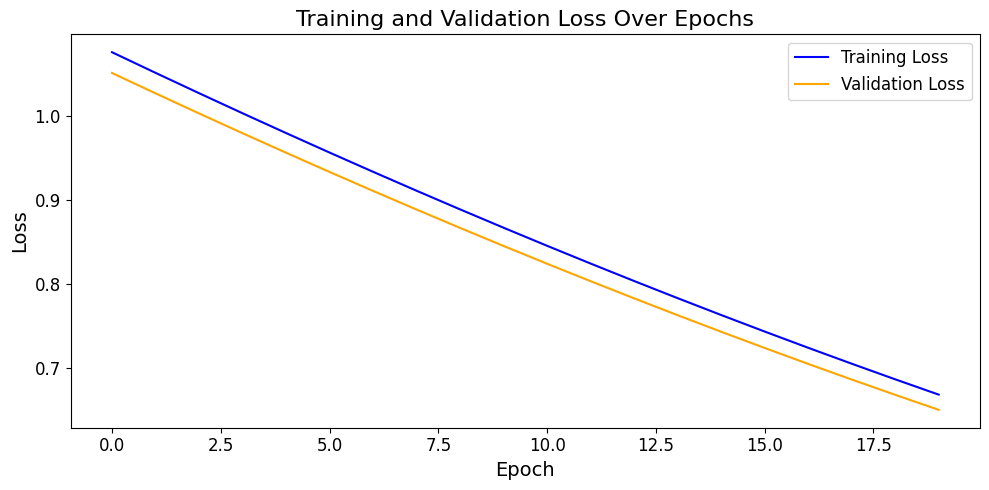

In [19]:
n_layers = 2
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = input_dim  

model = HybridDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))

plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

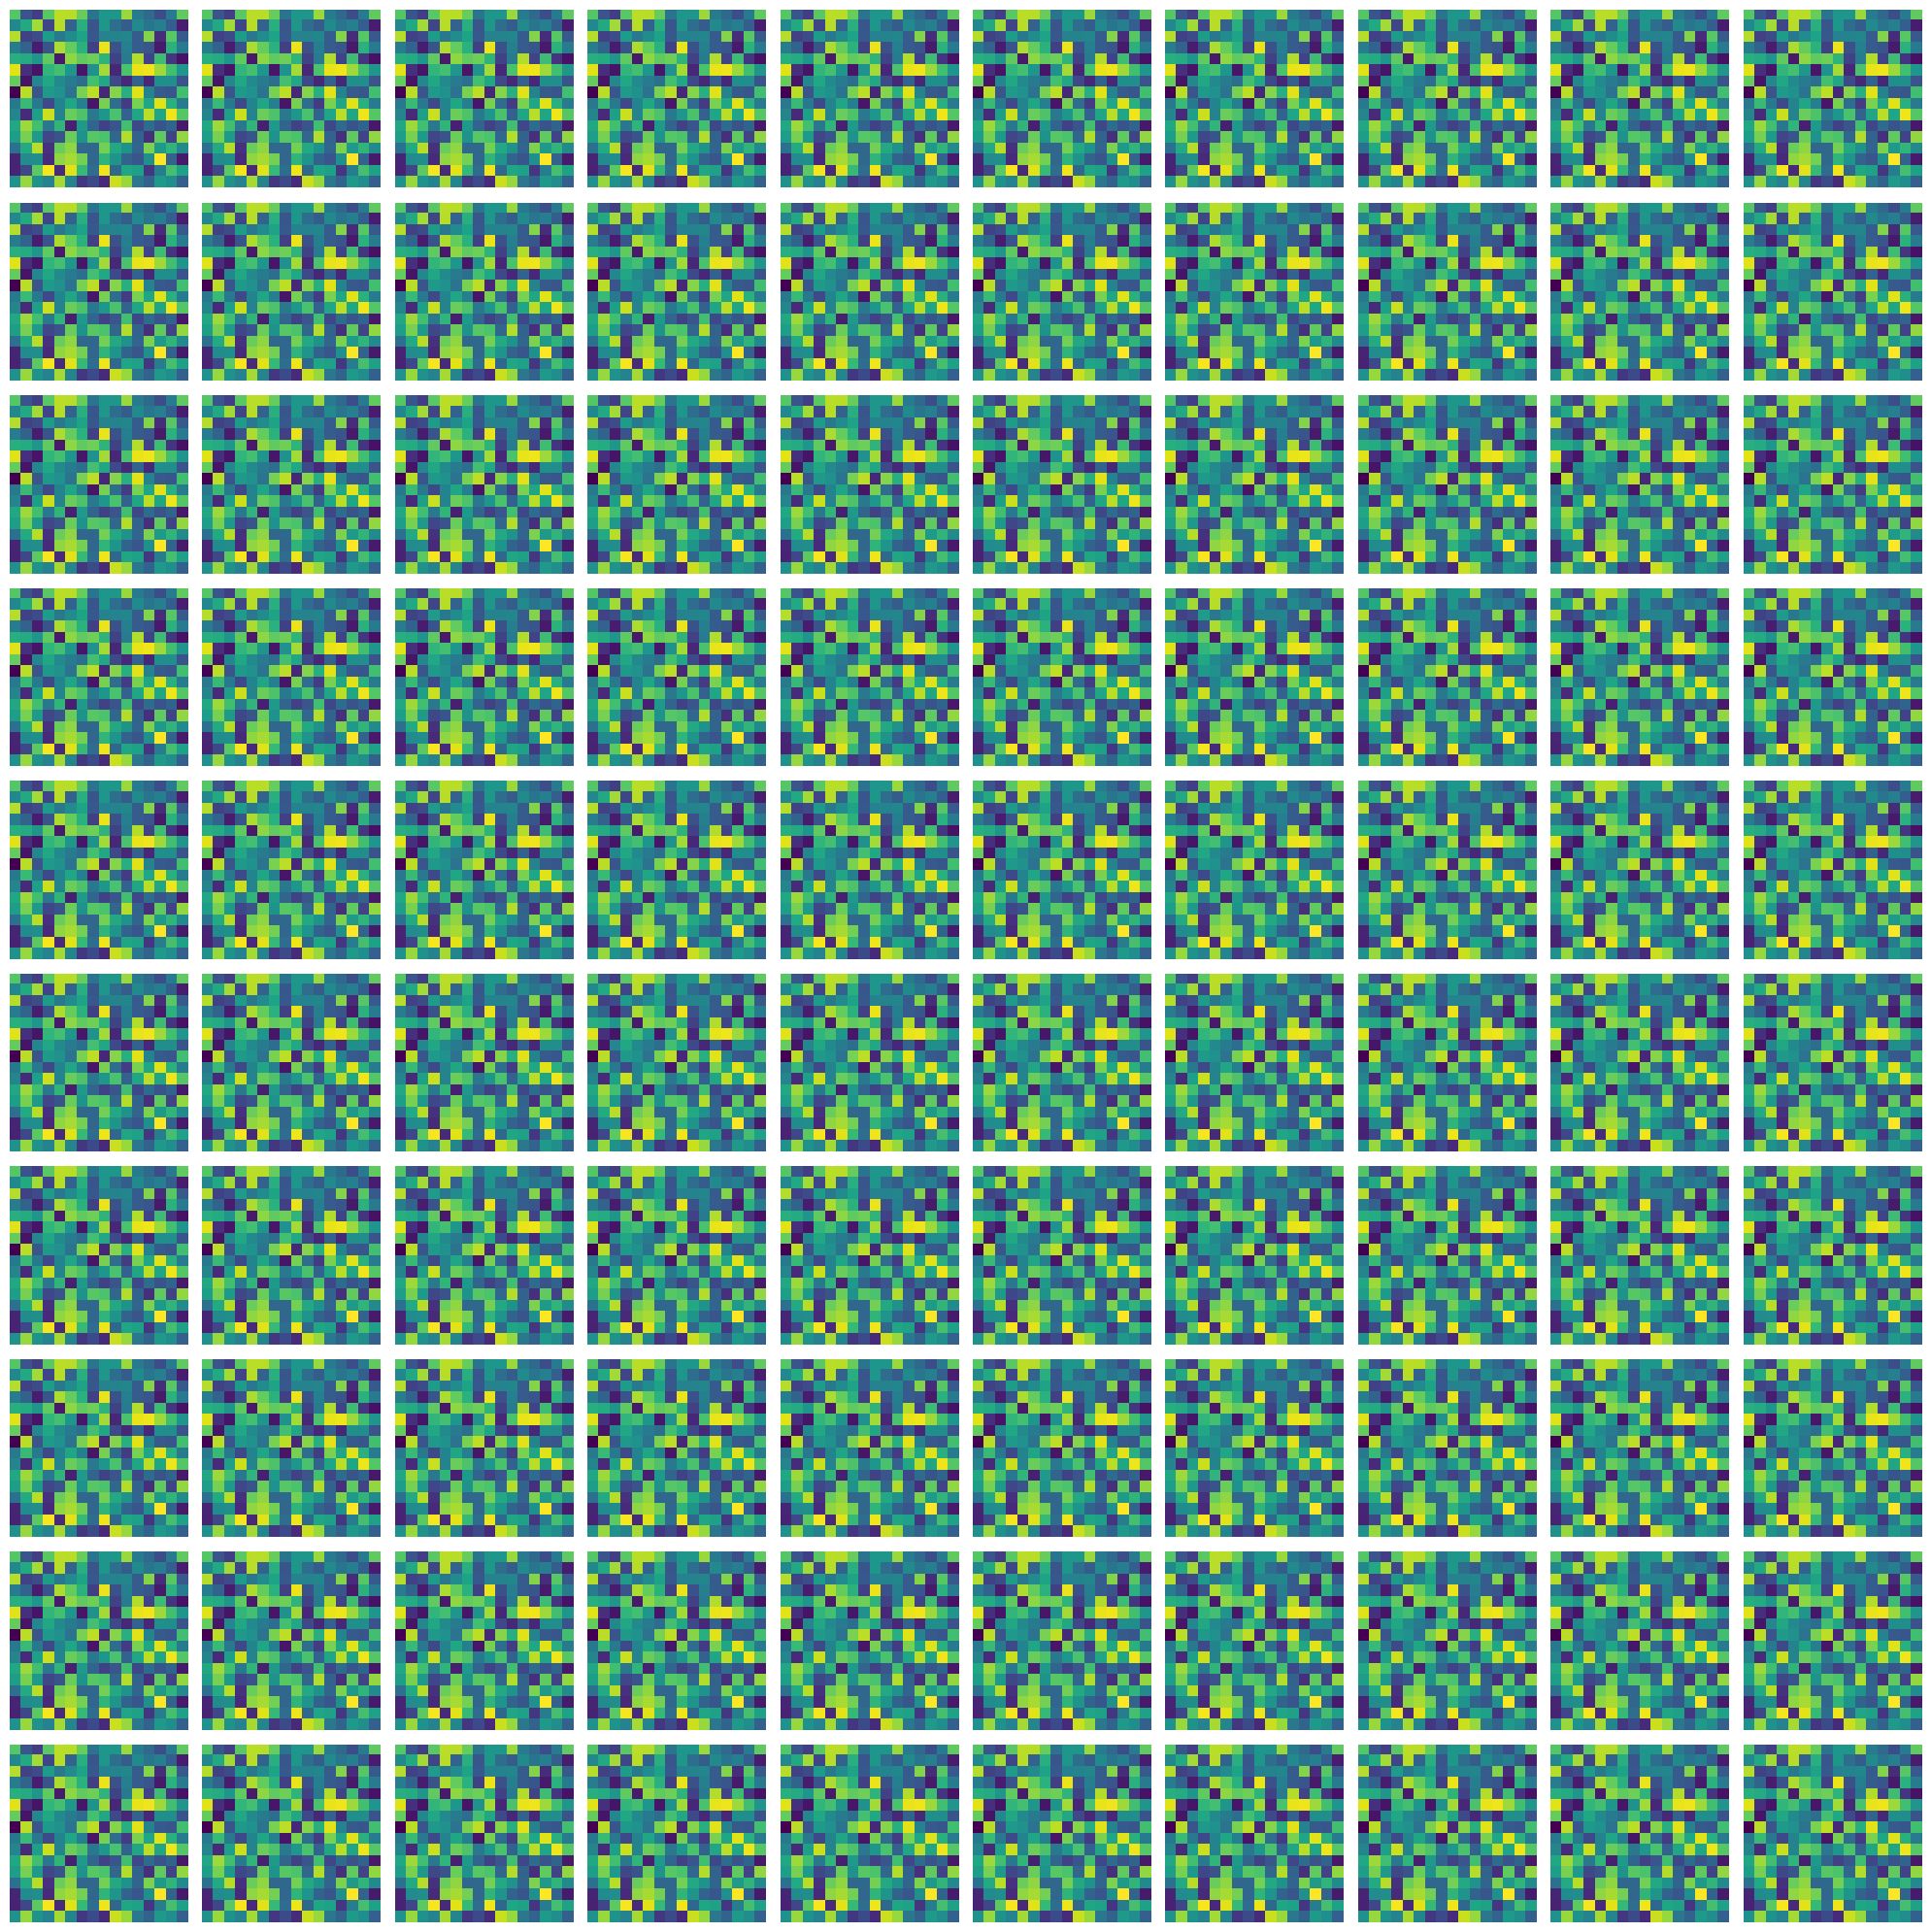

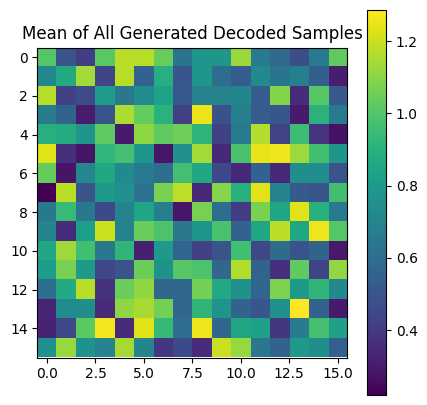

In [23]:
num_samples_to_generate = 100
new_images = generate_new_images(model, num_samples_to_generate)
plot_all_decoded_images(new_images)
plot_mean_decoded_images(new_images)

In [25]:
generated_data = new_images

real_data = data_X[:len(generated_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(flip(generated_data))
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

wasserstein_value = calculate_wasserstein(real_data, flip(generated_data))
print("Wasserstein 1 ", wasserstein_value)

FID  35.37338638858418
Wasserstein 1  0.3037794129084796


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


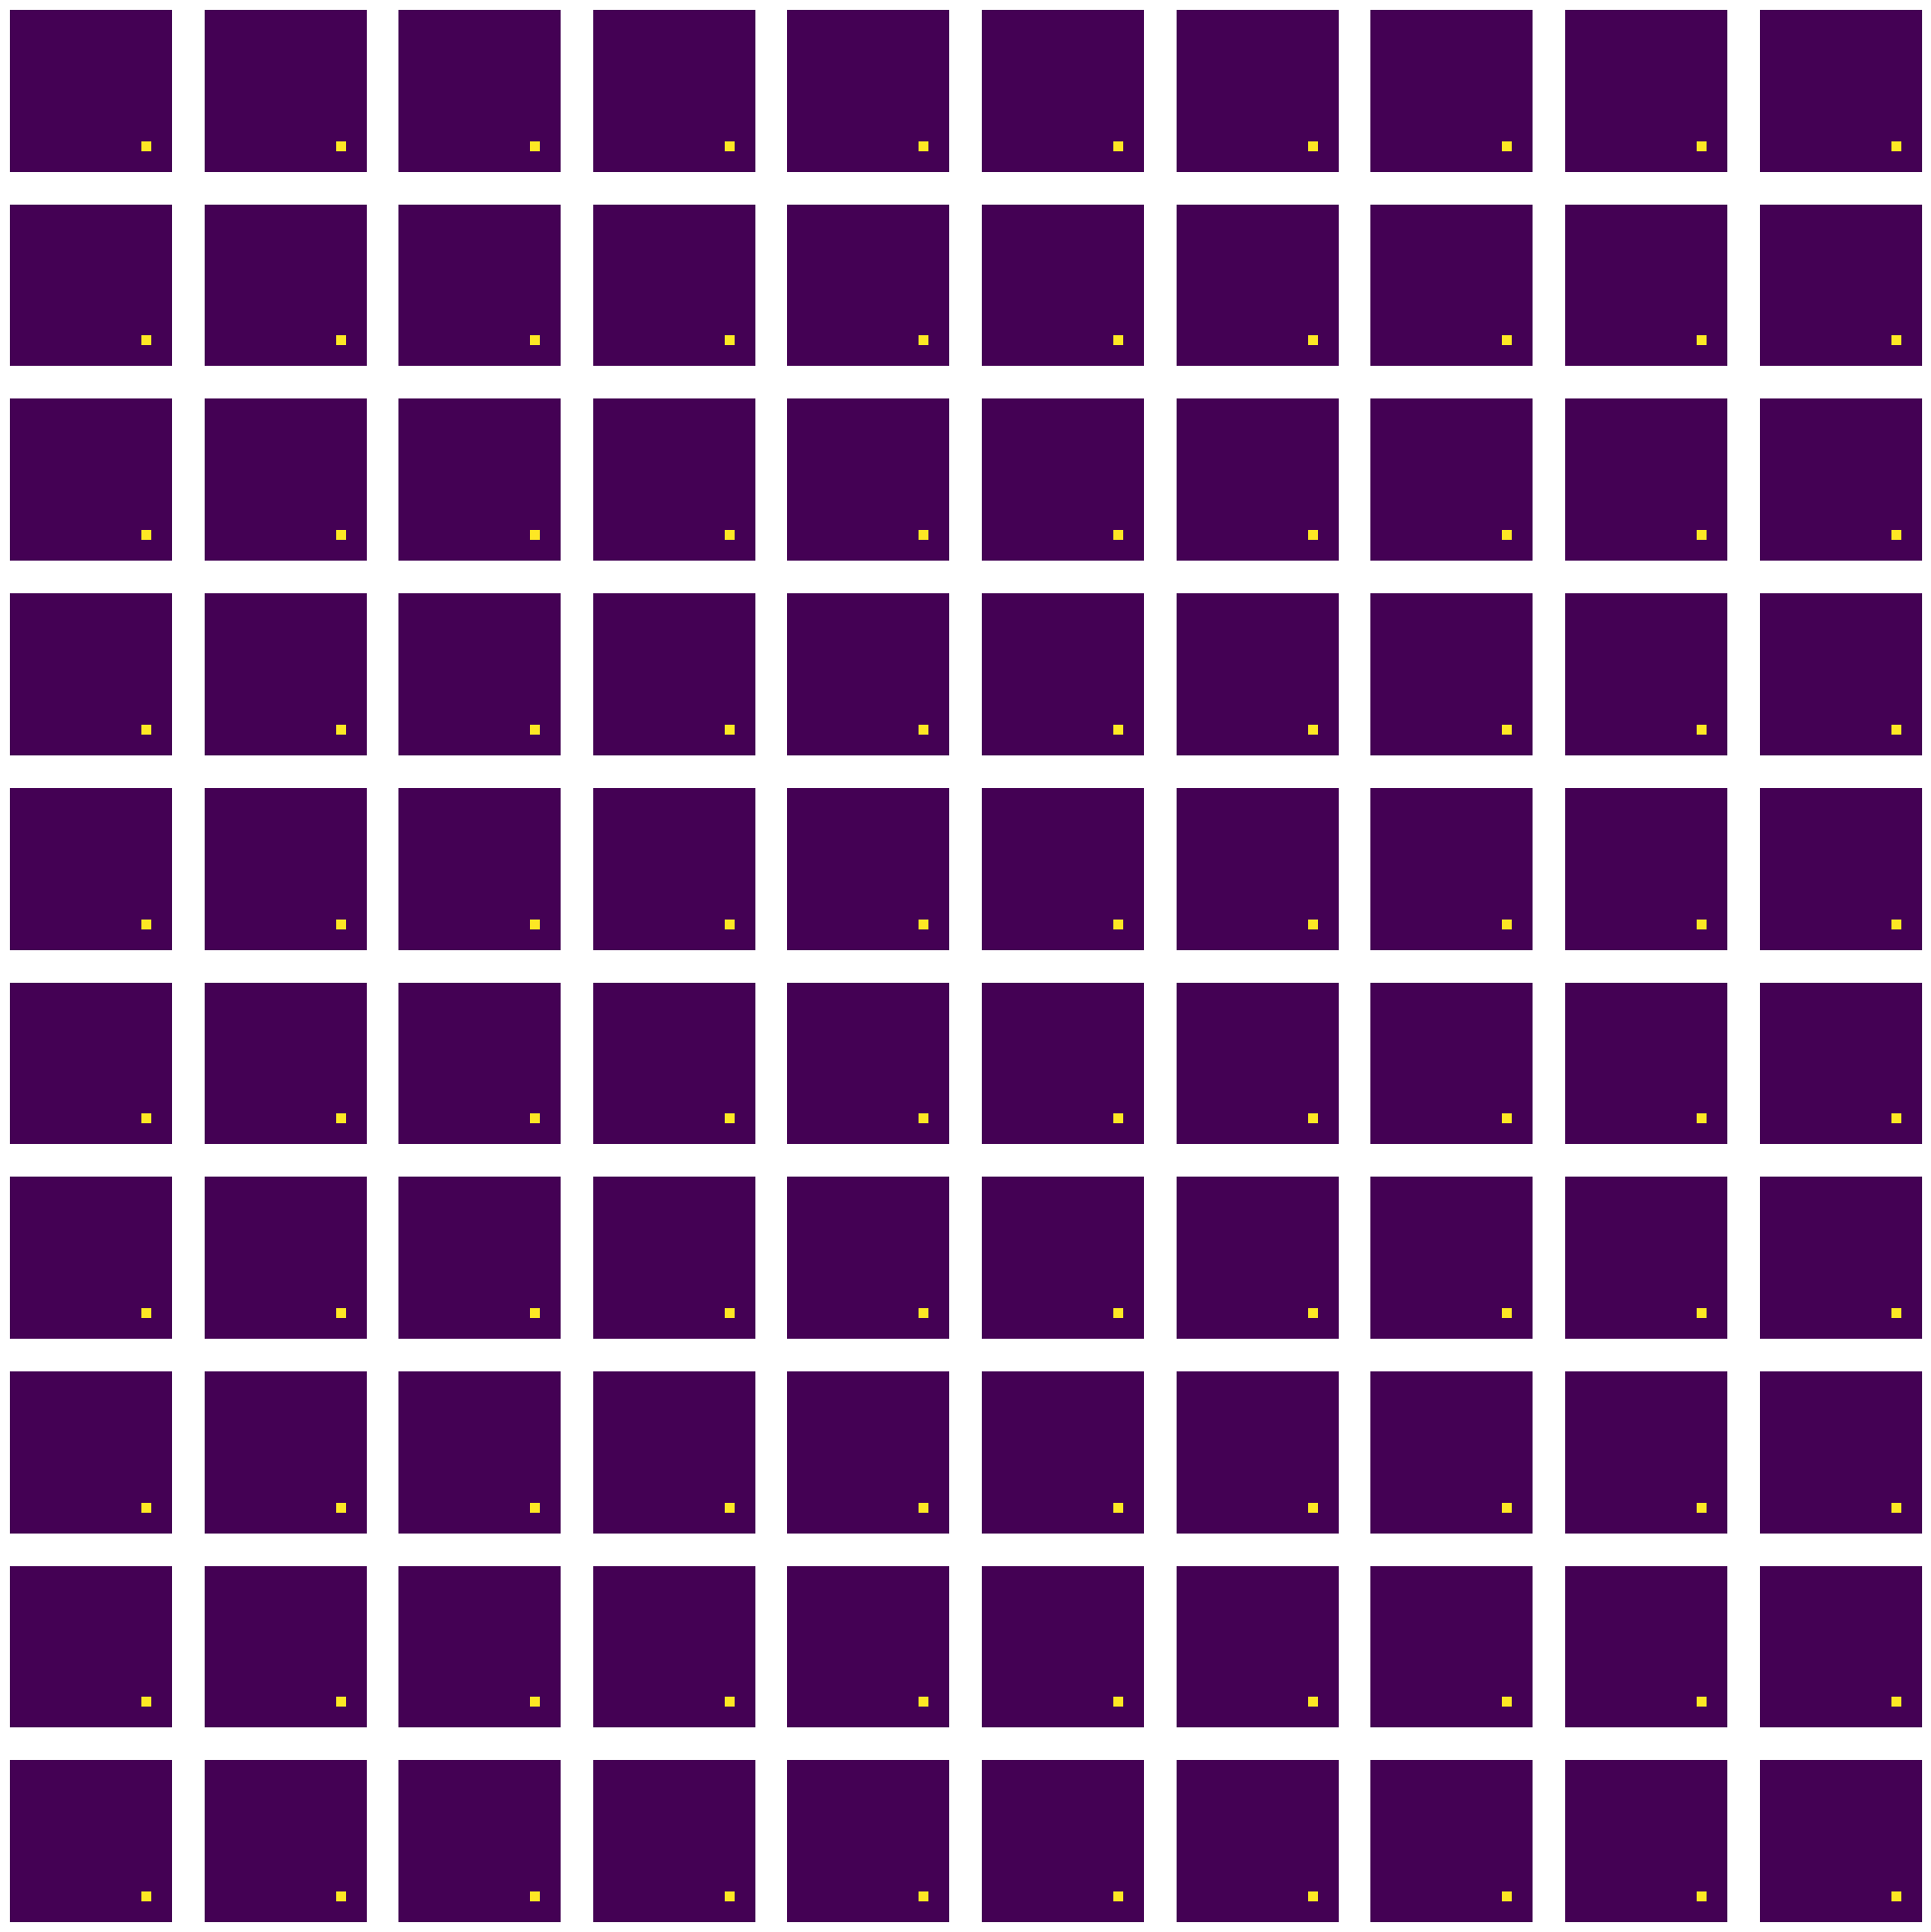

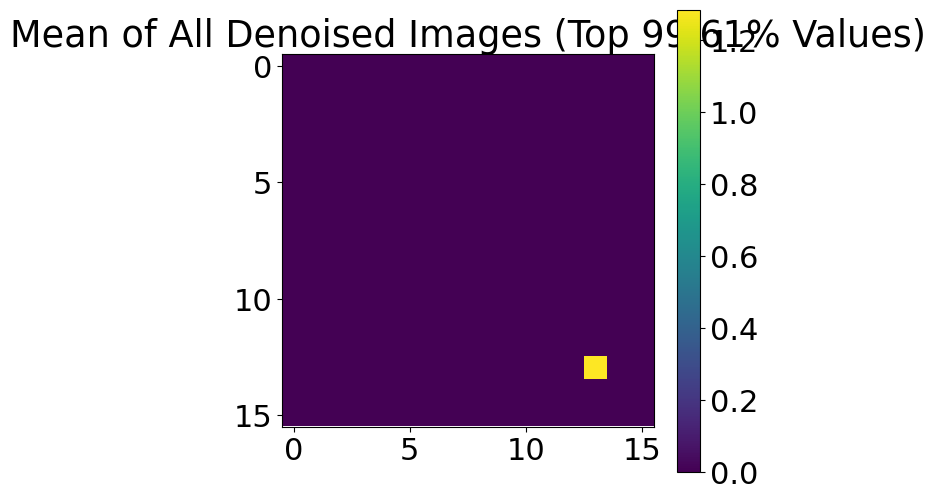

FID  2.752045409792049
Stable FID: 2.7462180406640706
Wasserstein 1  0.0026804037392139436


In [26]:
denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10), threshold_percent=99.61)

limit = 10
real_data = real_data[:limit]
denoised_images = denoised_images[:limit]
mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid_stable(mu_real, sigma_real, mu_gen, sigma_gen)
print("Stable FID:", fid)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein 1 ", wasserstein_value)